In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
clm5file = "/home/glemieux/Repos/fates/tools/landuse/tests/resources/CLM5_current_luhforest_deg025.nc"

In [148]:
ds = xr.open_dataset(clm5file)

Add coordinates to the dataset based on the lat/lon variables

In [149]:
ds['lat'] = ds.lat * 0.25 - 90. + 1./8.
ds['lon'] = ds.lon * 0.25 - 180. + 1./8.

Make a dataset that uses double precision

In [150]:
ds_pftdouble = ds.PCT_NAT_PFT.astype('float64')

Mask the data to only the maximum `pct_nat_pft` values

In [7]:
maxmask_double = ds_pftdouble.where(ds_pftdouble == ds_pftdouble.max(), drop=True)
print(maxmask_double)

<xarray.DataArray 'PCT_NAT_PFT' (natpft: 2, lat: 3, lon: 4)>
array([[[100.00001526, 100.00001526,          nan,          nan],
        [         nan,          nan, 100.00001526,          nan],
        [         nan,          nan,          nan,          nan]],

       [[         nan,          nan,          nan,          nan],
        [         nan,          nan,          nan,          nan],
        [         nan,          nan,          nan, 100.00001526]]])
Coordinates:
  * natpft   (natpft) int32 12 14
  * lat      (lat) float64 70.12 73.88 76.88
  * lon      (lon) float64 -28.88 -28.62 -26.62 16.38
Attributes:
    long_name:  percent plant functional type on the natural veg landunit (% ...
    units:      unitless


In [8]:
maxmask = ds.PCT_NAT_PFT.where(ds.PCT_NAT_PFT == ds.PCT_NAT_PFT.max(), drop=True)
print(maxmask)

<xarray.DataArray 'PCT_NAT_PFT' (natpft: 2, lat: 3, lon: 4)>
array([[[100.000015, 100.000015,        nan,        nan],
        [       nan,        nan, 100.000015,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan, 100.000015]]], dtype=float32)
Coordinates:
  * natpft   (natpft) int32 12 14
  * lat      (lat) float64 70.12 73.88 76.88
  * lon      (lon) float64 -28.88 -28.62 -26.62 16.38
Attributes:
    long_name:  percent plant functional type on the natural veg landunit (% ...
    units:      unitless


**Looks like we have some data where a given site has over 100%**

In [9]:
maxlon = maxmask.lon[0].item()
maxlat = maxmask.lat[0].item()
print(maxlat,maxlon)

70.125 -28.875


In [10]:
ds.sel(lon=maxlon,lat=maxlat)['PCT_NAT_PFT']

<xarray.DataArray 'PCT_NAT_PFT' (natpft: 15)>
array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
       100.000015,   0.      ,   0.      ], dtype=float32)
Coordinates:
  * natpft   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    lat      float64 70.12
    lon      float64 -28.88
Attributes:
    long_name:  percent plant functional type on the natural veg landunit (% ...
    units:      unitless

Back conversion for using `ncks` to double check this

In [25]:
def lon2idx(lon):
    return (lon - 1./8. + 180.) / 0.25
def lat2idx(lat):
    return (lat - 1./8. + 90.) / 0.25

In [28]:
print(lat2idx(maxlat),lon2idx(maxlon))

640.0 604.0


`ncks` confirms that this is over 100% for this pft.  This is fine for a single pft however since we'll simply normalize it out.  Are there cases in which there are multiple non-zero pfts for a given gridcell that all sum over 100%?

In [137]:
# drop values that are greater than 100 immediately
ds_lt100 = ds.PCT_NAT_PFT.where(ds.PCT_NAT_PFT < 100., drop=True)

# Are there any locations that sum to greater than 100?
overage = ds_lt100.sum(dim='natpft',min_count=1) > 100.
print((overage).any())

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)


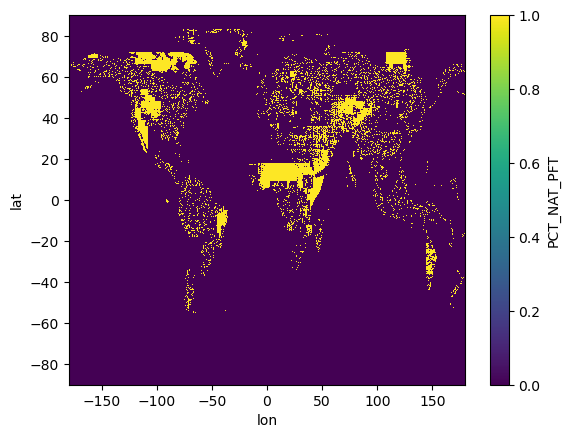

In [138]:
overage.plot()

In [139]:
ds_lt100.sel(lat=50,lon=-121,method='nearest').sum(dim='natpft') > 100.

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)
Coordinates:
    lat      float64 50.12
    lon      float64 -120.9

In [131]:
overageex = ds_lt100.sel(lat=50,lon=-121,method='nearest')

In [132]:
overfloat = overageex.astype('float64')

In [133]:
overfloat.sum(dim='natpft')

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(100.00000399)
Coordinates:
    lat      float64 50.12
    lon      float64 -120.9

In [134]:
overageex.sum(dim='natpft')

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(100.00001, dtype=float32)
Coordinates:
    lat      float64 50.12
    lon      float64 -120.9

In [140]:
overageex

<xarray.DataArray 'PCT_NAT_PFT' (natpft: 15)>
array([ 0.       ,  0.       , 88.34682  ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.7691156,  0.       ,
        0.       ,  0.       ,  0.       , 10.884071 ,  0.       ],
      dtype=float32)
Coordinates:
  * natpft   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    lat      float64 50.12
    lon      float64 -120.9
Attributes:
    long_name:  percent plant functional type on the natural veg landunit (% ...
    units:      unitless

In [146]:
print((overfloat / overfloat.sum(dim='natpft')).sum(dim='natpft') == 1.0)
print((overageex / overageex.sum(dim='natpft')).sum(dim='natpft') == 1.0)

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)
Coordinates:
    lat      float64 50.12
    lon      float64 -120.9
<xarray.DataArray 'PCT_NAT_PFT' ()>
array(False)
Coordinates:
    lat      float64 50.12
    lon      float64 -120.9


In [170]:
nobaregrounddouble = ds_pftdouble.sel(natpft=slice(1,None))

In [171]:
ds_pftdoublenorm = nobaregrounddouble / nobaregrounddouble.sum(dim='natpft')

In [181]:
ds_pftdoubelnorm_gt1 = ds_pftdoublenorm.sum(dim='natpft',min_count=1) > 1.0
ds_pftdoubelnorm_lt1 = ds_pftdoublenorm.sum(dim='natpft',min_count=1) < 1.0

In [204]:
(ds_pftdoublenorm.sum(dim='natpft',min_count=1) > 1.0).any()

<xarray.DataArray 'PCT_NAT_PFT' ()>
array(True)

In [208]:
((ds_pftdoublenorm.sum(dim='natpft',min_count=1).to_dataframe().dropna()) == 1.0).all()

PCT_NAT_PFT    False
dtype: bool

In [211]:
((ds_pftdoublenorm.sum(dim='natpft',min_count=1).to_dataframe().dropna()) != 1.0).any()

PCT_NAT_PFT    True
dtype: bool

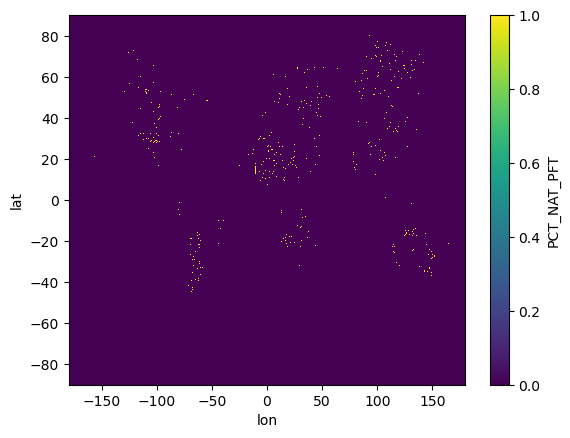

In [182]:
ds_pftdoubelnorm_gt1.plot()

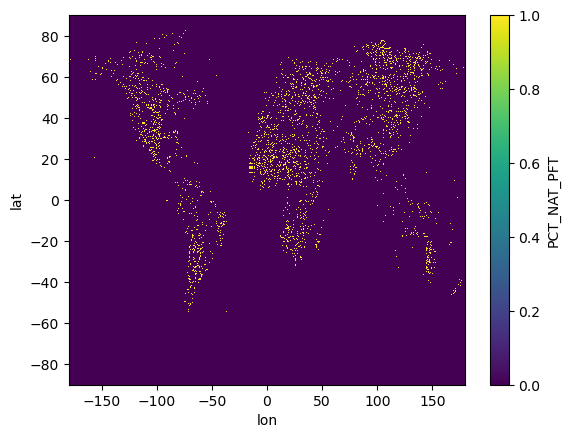

In [183]:
ds_pftdoubelnorm_lt1.plot()

In [280]:
maxgterror = ds_pftdoublenorm.where(ds_pftdoubelnorm_gt1).sum(dim='natpft',min_count=1).to_dataframe().dropna().max()[0]-1.0
print(abs(maxgterror))

2.220446049250313e-16


In [279]:
maxlterror = ds_pftdoublenorm.where(ds_pftdoubelnorm_lt1).sum(dim='natpft',min_count=1).to_dataframe().dropna().max()[0]-1.0
print(abs(maxlterror))

1.1102230246251565e-16


So it looks like using double precision calculations and a tolerance of ~`2.5e-16` should be good.  So the question is, do we adjust the values post scale?  It seems like a good idea, perhaps by adjusting the largest pft by the error term.

In [284]:
ds_pftdoublenorm_error = ds_pftdoublenorm.sum(dim='natpft',min_count=1) - 1.0

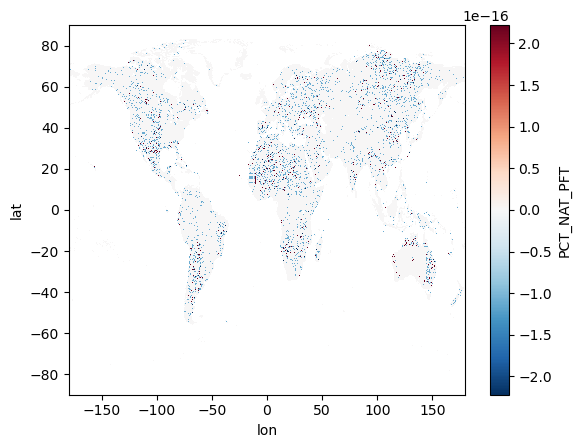

In [286]:
ds_pftdoublenorm_error.plot()

In [28]:
testarray = np.array([0., 0.9, 0.05, 0.05-3e-16, 0.0, 0.])
def adjust(testarray):
    iter = 0
    while testarray.sum() != 1.0:
        error = testarray.sum() - 1.0
        adj = testarray * error
        testarray = testarray - adj
        iter += 1
    print(iter)
    return testarray

In [30]:
print(testarray.sum()-1.0)
na = testarray
na = adjust(na)

-2.220446049250313e-16
1


In [31]:
(na*100.0).sum()

100.0

Due to floating point math, we'd could/should error correct. 

In [32]:
error = testarray.sum() - 1.0
adj = testarray * error
newarray = testarray - adj

In [38]:
newarray[1]

0.9000000000000002

In [39]:
newarray.sum() == 1.0

True